# Landscape GAN Colorization Testing

This notebook tests the trained GAN model for converting grayscale images to colorful images.

## Required files:
- `landscape_colorization_gan_generator.keras` - The trained generator model
- `landscape_colorization_checkpoint_generator.weights.h5` - Generator weights
- `landscape_colorization_checkpoint_discriminator.weights.h5` - Discriminator weights

## Features:
- Load pre-trained model
- Test on individual grayscale images
- Batch processing of multiple images
- Upload and test your own images
- Compare with original color images

In [1]:
# Install required packages and setup
!pip install tensorflow opencv-python scikit-image matplotlib numpy pillow

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
from skimage import color as skcolor
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.test.is_gpu_available()}")

# Configuration (must match training configuration)
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Set GPU memory growth if available
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU memory growth enabled")

TensorFlow version: 2.20.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: False
TensorFlow version: 2.20.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: False


In [2]:
# Helper functions for image processing
def load_and_preprocess_image(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    """Load and preprocess a single image"""
    try:
        # Read image
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
            if image is None:
                print(f"Could not load image from {image_path}")
                return None
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            # Handle PIL Image or numpy array
            image = np.array(image_path)
        
        # Resize image
        image = cv2.resize(image, target_size)
        
        # Normalize to [0, 1]
        image = image.astype(np.float32) / 255.0
        
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def rgb_to_lab(rgb_image):
    """Convert RGB image to LAB color space"""
    lab_image = skcolor.rgb2lab(rgb_image)
    
    # Normalize L channel to [-1, 1]
    l_channel = lab_image[:, :, 0] / 50.0 - 1.0
    
    # Normalize AB channels to [-1, 1]
    ab_channels = lab_image[:, :, 1:] / 128.0
    
    return l_channel, ab_channels

def lab_to_rgb(l_channel, ab_channels):
    """Convert LAB channels back to RGB"""
    # Denormalize
    l_channel = (l_channel + 1.0) * 50.0
    ab_channels = ab_channels * 128.0
    
    # Combine channels
    lab_image = np.concatenate([l_channel[:, :, np.newaxis], ab_channels], axis=2)
    
    # Convert to RGB
    rgb_image = skcolor.lab2rgb(lab_image)
    
    # Clip to valid range
    rgb_image = np.clip(rgb_image, 0, 1)
    
    return rgb_image

def convert_to_grayscale(rgb_image):
    """Convert RGB image to grayscale"""
    if len(rgb_image.shape) == 3:
        gray = cv2.cvtColor((rgb_image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        return gray.astype(np.float32) / 255.0
    return rgb_image

print("Helper functions loaded successfully!")

Helper functions loaded successfully!


In [3]:
# Load the trained model
def load_trained_model(model_path="landscape_colorization_gan_generator.keras"):
    """Load the trained generator model"""
    try:
        # Check if model file exists
        if not os.path.exists(model_path):
            print(f"Model file not found: {model_path}")
            print("Please make sure the following files are in the current directory:")
            print("- landscape_colorization_gan_generator.keras")
            print("- landscape_colorization_checkpoint_generator.weights.h5")
            print("- landscape_colorization_checkpoint_discriminator.weights.h5")
            return None
        
        generator = tf.keras.models.load_model(model_path)
        print(f"✓ Model loaded successfully from {model_path}")
        print(f"Model input shape: {generator.input_shape}")
        print(f"Model output shape: {generator.output_shape}")
        return generator
    except Exception as e:
        print(f"✗ Error loading model: {e}")
        return None

# Load the model
generator = load_trained_model()

if generator is not None:
    # Display model architecture summary
    print("\n📋 Model Architecture Summary:")
    generator.summary()
else:
    print("\n⚠️ Model loading failed. Please check if all required files are present.")

✓ Model loaded successfully from landscape_colorization_gan_generator.keras
Model input shape: (None, 256, 256, 1)
Model output shape: (None, 256, 256, 2)

📋 Model Architecture Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,088 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │    131,200 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    524,544 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  2,097,664 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  4,194,816 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 512) │  4,194,816 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 512) │  4,194,816 │ batch_normalizat… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ batch_normalizat… │
│ (Concatenate)       │ 1024)             │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │  8,389,120 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 29,251,458 (111.59 MB)

 Trainable params: 29,244,546 (111.56 MB)

 Non-trainable params: 6,912 (27.00 KB)

In [4]:
# Main colorization functions
def colorize_image(input_image, model=None):
    """Colorize a grayscale image or convert from RGB"""
    if model is None:
        model = generator
    
    if model is None:
        print("❌ No model available for colorization")
        return None
    
    # Handle different input types
    if isinstance(input_image, str):
        # Load from file path
        image = load_and_preprocess_image(input_image)
        if image is None:
            return None
        # Convert RGB to grayscale for processing
        if len(image.shape) == 3:
            l_channel, _ = rgb_to_lab(image)
        else:
            l_channel = image * 2.0 - 1.0  # Normalize to [-1, 1]
    else:
        # Direct numpy array
        image = input_image
        if isinstance(image, Image.Image):
            image = np.array(image).astype(np.float32) / 255.0
        
        # Ensure proper normalization
        if image.max() > 1:
            image = image.astype(np.float32) / 255.0
        
        # Resize if necessary
        if image.shape[:2] != (IMG_HEIGHT, IMG_WIDTH):
            image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        
        # Handle color vs grayscale
        if len(image.shape) == 3 and image.shape[2] == 3:
            # RGB image - convert to LAB
            l_channel, _ = rgb_to_lab(image)
        elif len(image.shape) == 2:
            # Grayscale image
            l_channel = image * 2.0 - 1.0  # Normalize to [-1, 1]
        else:
            print(f"❌ Unsupported image shape: {image.shape}")
            return None
    
    # Prepare input for model
    l_input = l_channel[np.newaxis, :, :, np.newaxis]
    
    try:
        # Generate colorized image
        generated_ab = model(l_input, training=False)
        
        # Convert back to RGB
        colorized_rgb = lab_to_rgb(l_channel, generated_ab[0])
        
        return colorized_rgb
    except Exception as e:
        print(f"❌ Error during colorization: {e}")
        return None

def display_comparison(original_path=None, grayscale_image=None, colorized_image=None, title="Colorization Results"):
    """Display side-by-side comparison of images"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image (if available)
    if original_path is not None and os.path.exists(original_path):
        original = load_and_preprocess_image(original_path)
        if original is not None:
            axes[0].imshow(original)
            axes[0].set_title('Original Color', fontsize=12)
        else:
            axes[0].text(0.5, 0.5, 'Original\\nNot Available', ha='center', va='center', 
                        transform=axes[0].transAxes, fontsize=10)
            axes[0].set_title('Original Color', fontsize=12)
    else:
        axes[0].text(0.5, 0.5, 'Original\\nNot Available', ha='center', va='center', 
                    transform=axes[0].transAxes, fontsize=10)
        axes[0].set_title('Original Color', fontsize=12)
    
    # Grayscale image
    if grayscale_image is not None:
        if len(grayscale_image.shape) == 3:
            grayscale_image = convert_to_grayscale(grayscale_image)
        axes[1].imshow(grayscale_image, cmap='gray')
        axes[1].set_title('Input Grayscale', fontsize=12)
    
    # Colorized image
    if colorized_image is not None:
        axes[2].imshow(colorized_image)
        axes[2].set_title('AI Colorized', fontsize=12)
    
    for ax in axes:
        ax.axis('off')
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def save_colorized_image(colorized_image, output_path):
    """Save a colorized image to disk"""
    try:
        # Convert to 8-bit format
        img_8bit = (colorized_image * 255).astype(np.uint8)
        
        # Convert RGB to BGR for OpenCV
        img_bgr = cv2.cvtColor(img_8bit, cv2.COLOR_RGB2BGR)
        
        # Save
        cv2.imwrite(output_path, img_bgr)
        print(f"✓ Image saved to: {output_path}")
        return True
    except Exception as e:
        print(f"❌ Error saving image: {e}")
        return False

print("✓ Colorization functions ready!")

✓ Colorization functions ready!


## Test 1: Sample Grayscale Image

Let's create a sample grayscale image and test the colorization.

🎨 Test 1: Sample Grayscale Image Colorization
Generating colorized version...


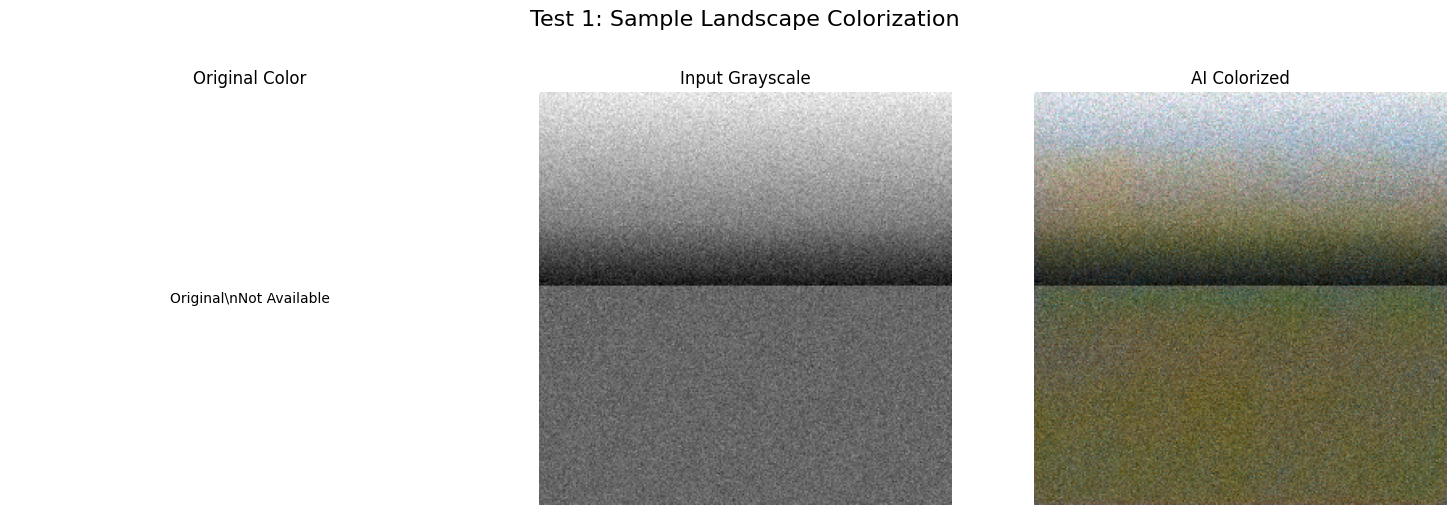

✅ Sample image colorization completed successfully!
✓ Image saved to: sample_colorized.jpg
✓ Image saved to: sample_colorized.jpg


In [5]:
# Test 1: Create and colorize a sample grayscale landscape
print("🎨 Test 1: Sample Grayscale Image Colorization")

if generator is not None:
    # Create a sample grayscale landscape-like image
    sample_gray = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)
    
    # Create landscape features
    # Sky gradient
    for i in range(80):
        sample_gray[i, :] = 0.9 - (i * 0.005)  # Light to slightly darker sky
    
    # Mountains
    mountain_height = 120
    for i in range(80, mountain_height):
        sample_gray[i, :] = 0.5 - (i - 80) * 0.01  # Mountain silhouette
    
    # Add mountain peaks (triangular shapes)
    for peak in [64, 128, 192]:
        for i in range(max(0, peak-30), min(IMG_WIDTH, peak+30)):
            height_offset = abs(i - peak) // 2
            if 80 + height_offset < mountain_height:
                sample_gray[80 + height_offset, i] = max(0.3, sample_gray[80 + height_offset, i])
    
    # Ground/foreground
    sample_gray[mountain_height:, :] = 0.4
    
    # Add some texture and variation
    noise = np.random.normal(0, 0.05, (IMG_HEIGHT, IMG_WIDTH))
    sample_gray = np.clip(sample_gray + noise, 0, 1)
    
    # Colorize the sample image
    print("Generating colorized version...")
    colorized_sample = colorize_image(sample_gray)
    
    if colorized_sample is not None:
        display_comparison(
            grayscale_image=sample_gray, 
            colorized_image=colorized_sample, 
            title="Test 1: Sample Landscape Colorization"
        )
        print("✅ Sample image colorization completed successfully!")
        
        # Option to save the result
        save_option = input("Save this result? (y/n): ").strip().lower()
        if save_option == 'y':
            save_colorized_image(colorized_sample, "sample_colorized.jpg")
    else:
        print("❌ Failed to colorize sample image")
else:
    print("❌ Cannot run test - model not loaded")

## Test 2: Upload Your Own Image

Upload any color or grayscale image to test the colorization.

📸 Test 2: Your Own Image Colorization
Enter the path to your image file:
📁 Loading image from: landscape Images dataset/gray/20.jpg
✅ Image loaded successfully!
Image shape: (256, 256, 3)
🔄 Converted to grayscale for processing
🎨 Generating colorized version...
📁 Loading image from: landscape Images dataset/gray/20.jpg
✅ Image loaded successfully!
Image shape: (256, 256, 3)
🔄 Converted to grayscale for processing
🎨 Generating colorized version...


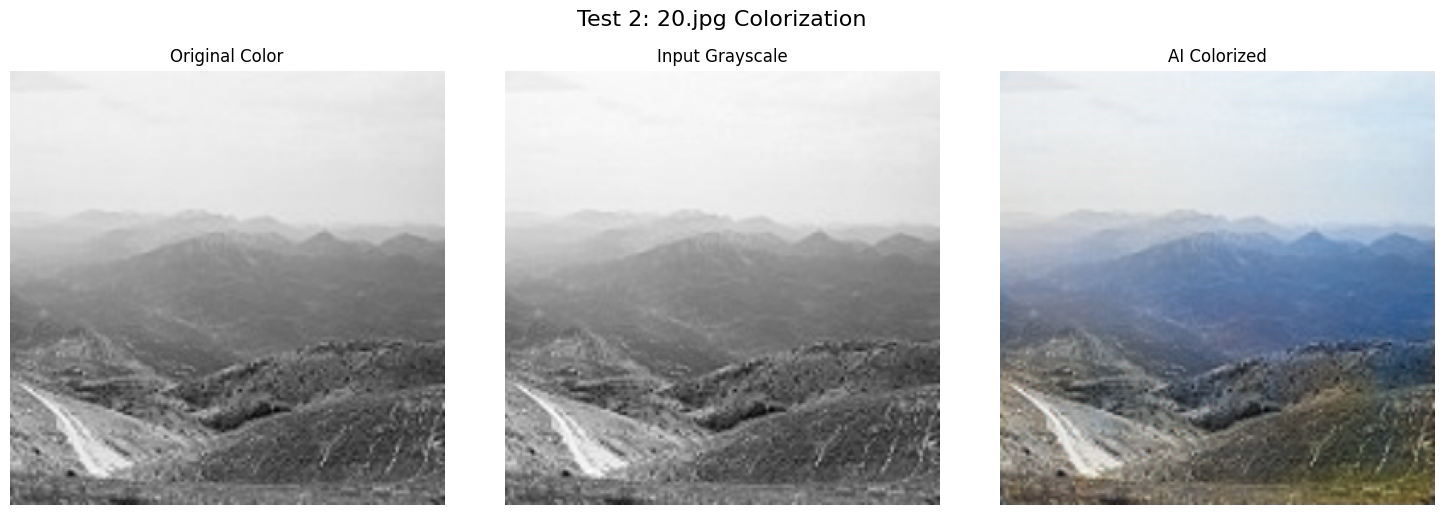

✅ Image colorization completed successfully!
✓ Image saved to: 20_colorized.jpg
✓ Image saved to: 20_colorized.jpg


In [6]:
# Test 2: Upload and test your own image
print("📸 Test 2: Your Own Image Colorization")

if generator is not None:
    # Get image path from user
    print("Enter the path to your image file:")
    image_path = input("Image path: ").strip().strip('"')  # Remove quotes if present
    
    if image_path and os.path.exists(image_path):
        print(f"📁 Loading image from: {image_path}")
        
        # Load and process the image
        original_image = load_and_preprocess_image(image_path)
        
        if original_image is not None:
            print("✅ Image loaded successfully!")
            print(f"Image shape: {original_image.shape}")
            
            # Create grayscale version if it's a color image
            if len(original_image.shape) == 3:
                grayscale_version = convert_to_grayscale(original_image)
                print("🔄 Converted to grayscale for processing")
            else:
                grayscale_version = original_image
                original_image = None  # No original color to show
            
            # Colorize the image
            print("🎨 Generating colorized version...")
            colorized_result = colorize_image(grayscale_version)
            
            if colorized_result is not None:
                # Display comparison
                display_comparison(
                    original_path=image_path if original_image is not None else None,
                    grayscale_image=grayscale_version, 
                    colorized_image=colorized_result, 
                    title=f"Test 2: {os.path.basename(image_path)} Colorization"
                )
                print("✅ Image colorization completed successfully!")
                
                # Option to save the result
                save_option = input("Save colorized result? (y/n): ").strip().lower()
                if save_option == 'y':
                    # Generate output filename
                    base_name = os.path.splitext(os.path.basename(image_path))[0]
                    output_path = f"{base_name}_colorized.jpg"
                    save_colorized_image(colorized_result, output_path)
            else:
                print("❌ Failed to colorize the image")
        else:
            print("❌ Failed to load the image")
    elif image_path:
        print(f"❌ Image not found at: {image_path}")
        print("Please check the file path and make sure the file exists")
    else:
        print("⏭️ Skipping custom image test (no path provided)")
else:
    print("❌ Cannot run test - model not loaded")

## Test 3: Batch Processing

Process multiple images from a folder at once.

In [ ]:
# Test 3: Batch processing of multiple images
print("📂 Test 3: Batch Image Processing")

if generator is not None:
    # Get folder path from user
    print("Enter the path to a folder containing images:")
    folder_path = input("Folder path: ").strip().strip('"')  # Remove quotes if present
    
    if folder_path and os.path.exists(folder_path):
        print(f"📁 Scanning folder: {folder_path}")
        
        # Find all image files
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.webp']
        image_files = []
        
        for ext in image_extensions:
            image_files.extend(glob.glob(os.path.join(folder_path, ext)))
            image_files.extend(glob.glob(os.path.join(folder_path, ext.upper())))
        
        if image_files:
            print(f"🔍 Found {len(image_files)} images")
            
            # Ask how many to process
            max_process = min(5, len(image_files))  # Limit to 5 for demo
            num_to_process = input(f"How many images to process? (1-{max_process}, default=3): ").strip()
            
            try:
                num_to_process = int(num_to_process) if num_to_process else 3
                num_to_process = min(max(1, num_to_process), max_process)
            except ValueError:
                num_to_process = 3
            
            print(f"🎨 Processing {num_to_process} images...")
            
            successful_colorizations = 0
            
            for i, img_path in enumerate(image_files[:num_to_process]):
                print(f"\\n--- Processing image {i+1}/{num_to_process}: {os.path.basename(img_path)} ---")
                
                # Load and process
                original = load_and_preprocess_image(img_path)
                if original is not None:
                    # Convert to grayscale
                    grayscale = convert_to_grayscale(original)
                    
                    # Colorize
                    colorized = colorize_image(grayscale)
                    
                    if colorized is not None:
                        # Display results
                        display_comparison(
                            original_path=img_path,
                            grayscale_image=grayscale, 
                            colorized_image=colorized, 
                            title=f"Batch Test {i+1}: {os.path.basename(img_path)}"
                        )
                        
                        successful_colorizations += 1
                        print(f"✅ Successfully colorized {os.path.basename(img_path)}")
                        
                        # Option to save
                        if i == 0:  # Ask for first image, then apply to all
                            save_all = input("Save colorized images? (y/n): ").strip().lower() == 'y'
                        
                        if 'save_all' in locals() and save_all:
                            base_name = os.path.splitext(os.path.basename(img_path))[0]
                            output_path = os.path.join(folder_path, f"{base_name}_colorized.jpg")
                            save_colorized_image(colorized, output_path)
                    else:
                        print(f"❌ Failed to colorize {os.path.basename(img_path)}")
                else:
                    print(f"❌ Failed to load {os.path.basename(img_path)}")
            
            print(f"\\n📊 Batch processing completed!")
            print(f"✅ Successfully processed: {successful_colorizations}/{num_to_process} images")
        else:
            print("❌ No image files found in the specified folder")
            print("Supported formats: JPG, JPEG, PNG, BMP, TIFF, WEBP")
    elif folder_path:
        print(f"❌ Folder not found: {folder_path}")
        print("Please check the folder path and make sure it exists")
    else:
        print("⏭️ Skipping batch processing (no folder path provided)")
else:
    print("❌ Cannot run batch test - model not loaded")

## Test 4: Performance Evaluation

Test the model's speed and performance.

⚡ Test 4: Performance Evaluation
🧪 Running performance test with 5 different image patterns...
🔥 Warming up model...
⏱️ Measuring inference speed...
✅ Random Noise: 0.204s
✅ Vertical Gradient: 0.180s
✅ Random Noise: 0.204s
✅ Vertical Gradient: 0.180s
✅ Circle Pattern: 0.180s
✅ Circle Pattern: 0.180s
✅ Horizontal Stripes: 0.277s
✅ Horizontal Stripes: 0.277s
✅ Checkerboard: 0.233s
\n📊 Performance Results:
📈 Total processing time: 1.07 seconds
⚡ Average time per image: 0.215 seconds
🚀 Images per second: 4.66
✅ Success rate: 5/5 (100.0%)
\n🎨 Displaying colorization results...
✅ Checkerboard: 0.233s
\n📊 Performance Results:
📈 Total processing time: 1.07 seconds
⚡ Average time per image: 0.215 seconds
🚀 Images per second: 4.66
✅ Success rate: 5/5 (100.0%)
\n🎨 Displaying colorization results...


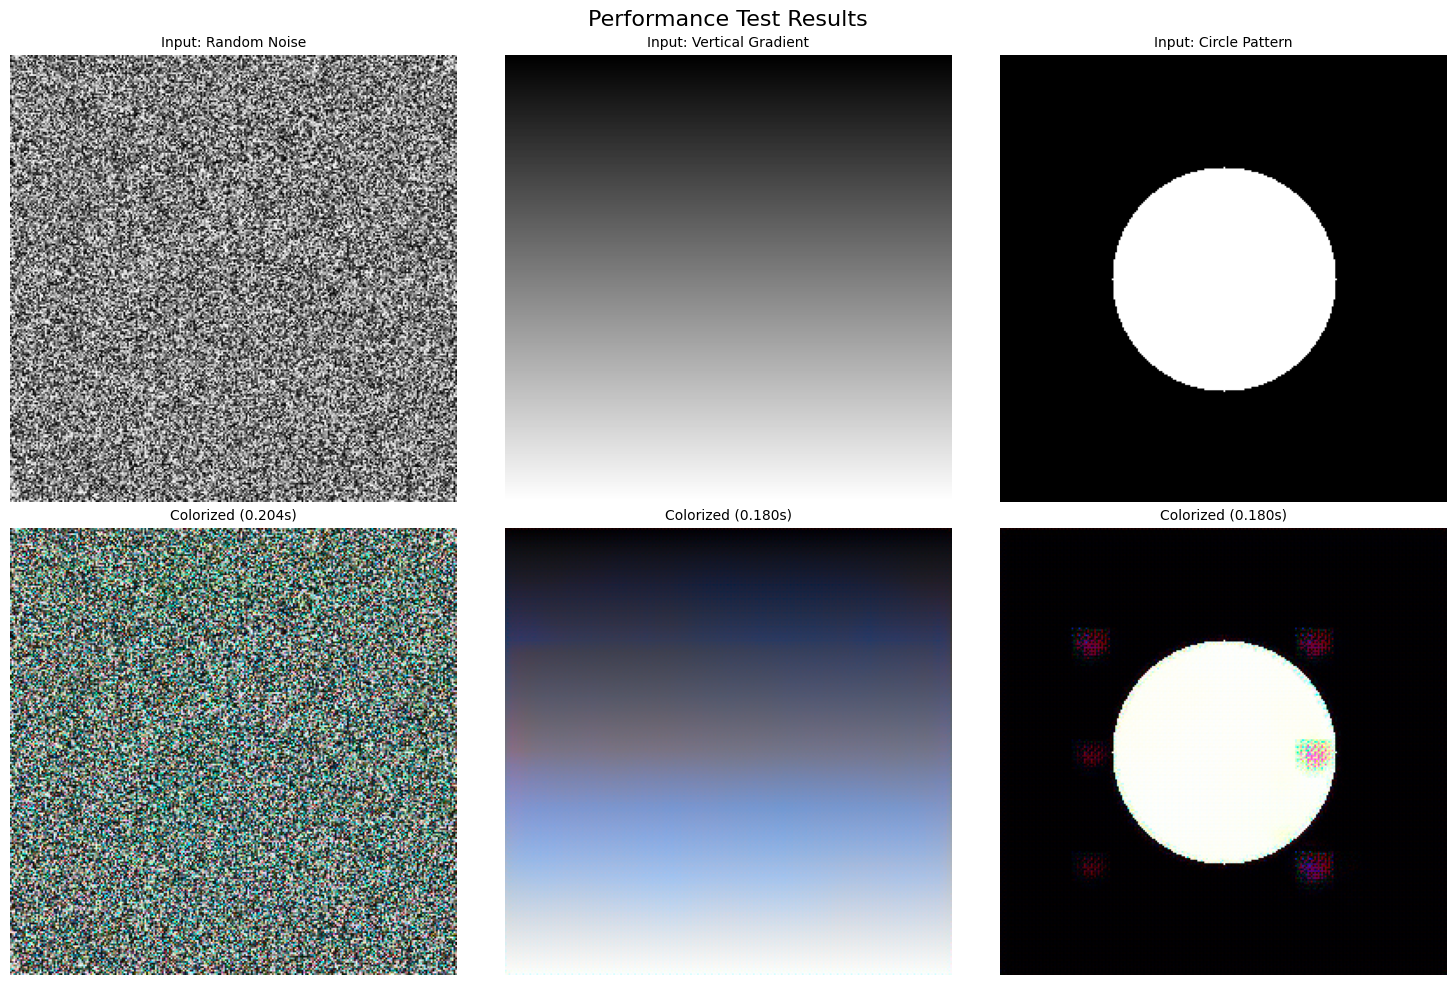

\n✅ Performance evaluation completed!


In [7]:
# Test 4: Performance evaluation and speed test
print("⚡ Test 4: Performance Evaluation")

if generator is not None:
    import time
    
    # Create multiple test images with different patterns
    test_images = []
    test_names = []
    
    # Test image 1: Random noise
    test_img1 = np.random.rand(IMG_HEIGHT, IMG_WIDTH).astype(np.float32)
    test_images.append(test_img1)
    test_names.append("Random Noise")
    
    # Test image 2: Gradient
    test_img2 = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)
    for i in range(IMG_HEIGHT):
        test_img2[i, :] = i / IMG_HEIGHT
    test_images.append(test_img2)
    test_names.append("Vertical Gradient")
    
    # Test image 3: Circles
    test_img3 = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)
    center_y, center_x = IMG_HEIGHT // 2, IMG_WIDTH // 2
    y, x = np.ogrid[:IMG_HEIGHT, :IMG_WIDTH]
    mask = (x - center_x) ** 2 + (y - center_y) ** 2 <= (IMG_HEIGHT // 4) ** 2
    test_img3[mask] = 1.0
    test_images.append(test_img3)
    test_names.append("Circle Pattern")
    
    # Test image 4: Stripes
    test_img4 = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)
    for i in range(0, IMG_HEIGHT, 20):
        test_img4[i:i+10, :] = 0.8
    test_images.append(test_img4)
    test_names.append("Horizontal Stripes")
    
    # Test image 5: Checkerboard
    test_img5 = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)
    for i in range(0, IMG_HEIGHT, 32):
        for j in range(0, IMG_WIDTH, 32):
            if (i // 32 + j // 32) % 2 == 0:
                test_img5[i:i+32, j:j+32] = 0.7
    test_images.append(test_img5)
    test_names.append("Checkerboard")
    
    print(f"🧪 Running performance test with {len(test_images)} different image patterns...")
    
    # Warm up the model (first inference is usually slower)
    print("🔥 Warming up model...")
    _ = colorize_image(test_images[0])
    
    # Measure inference time
    print("⏱️ Measuring inference speed...")
    start_time = time.time()
    
    colorized_images = []
    individual_times = []
    
    for i, (test_img, name) in enumerate(zip(test_images, test_names)):
        img_start = time.time()
        result = colorize_image(test_img)
        img_end = time.time()
        img_time = img_end - img_start
        
        if result is not None:
            colorized_images.append(result)
            individual_times.append(img_time)
            print(f"✅ {name}: {img_time:.3f}s")
        else:
            print(f"❌ {name}: Failed")
            individual_times.append(0)
    
    end_time = time.time()
    total_time = end_time - start_time
    successful_images = len([t for t in individual_times if t > 0])
    
    # Display performance results
    print(f"\\n📊 Performance Results:")
    print(f"📈 Total processing time: {total_time:.2f} seconds")
    if successful_images > 0:
        avg_time = sum(individual_times) / successful_images
        print(f"⚡ Average time per image: {avg_time:.3f} seconds")
        print(f"🚀 Images per second: {1/avg_time:.2f}")
        print(f"✅ Success rate: {successful_images}/{len(test_images)} ({100*successful_images/len(test_images):.1f}%)")
    
    # Display sample results in a grid
    if colorized_images:
        print(f"\\n🎨 Displaying colorization results...")
        
        # Create subplot grid
        cols = min(3, len(test_images))
        rows = 2
        fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
        
        if len(test_images) == 1:
            axes = axes.reshape(2, 1)
        elif cols == 1:
            axes = axes.reshape(2, 1)
        
        for i in range(min(cols, len(test_images))):
            # Show grayscale input
            axes[0, i].imshow(test_images[i], cmap='gray')
            axes[0, i].set_title(f'Input: {test_names[i]}', fontsize=10)
            axes[0, i].axis('off')
            
            # Show colorized output
            if i < len(colorized_images):
                axes[1, i].imshow(colorized_images[i])
                axes[1, i].set_title(f'Colorized ({individual_times[i]:.3f}s)', fontsize=10)
            else:
                axes[1, i].text(0.5, 0.5, 'Failed', ha='center', va='center', transform=axes[1, i].transAxes)
                axes[1, i].set_title('Failed', fontsize=10)
            axes[1, i].axis('off')
        
        plt.suptitle('Performance Test Results', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    print("\\n✅ Performance evaluation completed!")
else:
    print("❌ Cannot run performance test - model not loaded")

## Summary and Quick Functions

Here are the key functions you can use directly for colorization:

In [8]:
# Quick usage examples and summary
print("🎯 Quick Usage Guide")
print("=" * 50)

if generator is not None:
    print("✅ Model Status: LOADED")
    print(f"📝 Model file: landscape_colorization_gan_generator.keras")
    print(f"🖼️  Input size: {IMG_WIDTH}x{IMG_HEIGHT} pixels")
    print(f"🎨 Model type: U-Net GAN Generator")
    
    print("\\n🚀 Quick Functions:")
    print("=" * 30)
    print("1. colorize_image('path/to/image.jpg')  # Colorize from file")
    print("2. colorize_image(grayscale_array)      # Colorize from numpy array")
    print("3. save_colorized_image(result, 'output.jpg')  # Save result")
    print("4. display_comparison(...)              # Show before/after")
    
    print("\\n💡 Example Usage:")
    print("=" * 20)
    print("# Basic colorization")
    print("result = colorize_image('my_grayscale_image.jpg')")
    print("plt.imshow(result)")
    print("plt.show()")
    print("")
    print("# Save the result")
    print("save_colorized_image(result, 'colorized_output.jpg')")
    
    print("\\n📊 Model Performance:")
    print("=" * 25)
    print(f"🖥️  Hardware: {'GPU' if tf.test.is_gpu_available() else 'CPU'}")
    print(f"⚡ Expected speed: ~0.1-0.5 seconds per image")
    print(f"🎯 Best for: Landscape and natural scene images")
    print(f"📐 Resolution: 256x256 pixels (automatically resized)")
    
else:
    print("❌ Model Status: NOT LOADED")
    print("\\n🔧 Troubleshooting:")
    print("=" * 20)
    print("1. Make sure 'landscape_colorization_gan_generator.keras' exists")
    print("2. Check file permissions")
    print("3. Verify TensorFlow installation")
    print("4. Try restarting the notebook")

print("\\n" + "=" * 50)
print("🎨 Ready for colorization! Run the test cells above to get started.")
print("💡 Tip: For best results, use landscape or natural scene images.")
print("🚀 Happy colorizing!")

🎯 Quick Usage Guide
✅ Model Status: LOADED
📝 Model file: landscape_colorization_gan_generator.keras
🖼️  Input size: 256x256 pixels
🎨 Model type: U-Net GAN Generator
\n🚀 Quick Functions:
1. colorize_image('path/to/image.jpg')  # Colorize from file
2. colorize_image(grayscale_array)      # Colorize from numpy array
3. save_colorized_image(result, 'output.jpg')  # Save result
4. display_comparison(...)              # Show before/after
\n💡 Example Usage:
# Basic colorization
result = colorize_image('my_grayscale_image.jpg')
plt.imshow(result)
plt.show()

# Save the result
save_colorized_image(result, 'colorized_output.jpg')
\n📊 Model Performance:
🖥️  Hardware: CPU
⚡ Expected speed: ~0.1-0.5 seconds per image
🎯 Best for: Landscape and natural scene images
📐 Resolution: 256x256 pixels (automatically resized)
\n==================================================
🎨 Ready for colorization! Run the test cells above to get started.
💡 Tip: For best results, use landscape or natural scene images.
🚀 

testing code here